# Card Search with CLIP

In this notebook, we use CLIP to create embeddings for cards so that we can search for cards using natural language. Our query is embedded with CLIP and we perform cosine similarity and return the top k similar results.

To keep file sizes small, we opt for a gzip'd binary file containing a JSON. For ~19,000 cards the resulting file is about 87mb.

## 1 Download cards


In [ ]:
import json
import os
import gzip

from fastai.vision.all import *
from fastdownload import download_url
from transformers import pipeline, CLIPProcessor, CLIPModel
from google.colab import drive

from PIL import Image
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [1]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -Uqq fastai

In [3]:
# Currently loaded sets ~19600 cards in total
!ls -l gdrive/MyDrive/4ZP6\:\ Capstone/data/jsons | head -n 5

total 30686
-rw------- 1 root root  12561 Jan 11 16:51 cards_2011bw.json
-rw------- 1 root root  12548 Jan 11 16:51 cards_2012bw.json
-rw------- 1 root root   9144 Jan 11 16:51 cards_2014xy.json
-rw------- 1 root root   9029 Jan 11 16:51 cards_2015xy.json


In [5]:
path = Path('gdrive/MyDrive/4ZP6: Capstone/data/jsons')

In [6]:
pokemon_sets = os.listdir(path)
pokemon_sets[0:5], len(pokemon_sets)

(['sets.json',
  'cards_bw9.json',
  'cards_bw10.json',
  'cards_ex2.json',
  'cards_neo4.json'],
 186)

In [12]:
all_cards = []
for pokemon_set in pokemon_sets:
    with open(path/pokemon_set, 'r') as file:
        set_data = json.load(file)
        if 'cards' not in set_data:
            continue
        for card in set_data['cards']:
            if 'image' not in card:
                continue
            all_cards.append(card)

len(all_cards), all_cards[0]

(19159,
 {'category': 'Pokemon',
  'id': 'bw9-1',
  'illustrator': 'Sumiyoshi Kizuki',
  'image': 'https://assets.tcgdex.net/en/bw/bw9/1',
  'localId': '1',
  'name': 'Weedle',
  'rarity': 'Common',
  'set': {'cardCount': {'official': 116, 'total': 122},
   'id': 'bw9',
   'logo': 'https://assets.tcgdex.net/en/bw/bw9/logo',
   'name': 'Plasma Freeze',
   'symbol': 'https://assets.tcgdex.net/univ/bw/bw9/symbol'},
  'variants': {'firstEdition': False,
   'holo': True,
   'normal': True,
   'reverse': True,
   'wPromo': False},
  'variants_detailed': [{'type': 'normal', 'size': 'standard'},
   {'type': 'reverse', 'size': 'standard'},
   {'type': 'holo', 'size': 'standard'}],
  'dexId': [13],
  'hp': 50,
  'types': ['Grass'],
  'stage': 'Basic',
  'attacks': [{'cost': ['Grass'],
    'name': 'Triple Stab',
    'effect': 'Flip 3 coins. This attack does 10 damage times the number of heads.',
    'damage': 10}],
  'weaknesses': [{'type': 'Fire', 'value': '×2'}],
  'retreat': 1,
  'legal': {'st

In [13]:
id_to_url = {}
id_to_name = {}
for card in all_cards:
    id_to_url[card['id']] = f'{card['image']}/high.jpg'
    id_to_name[card['id']] = card['name']

In [21]:
def download_imgs_inner(dest, inp):
    name,url = inp
    url = url.split("?")[0]
    url_path = Path(url)
    suffix = url_path.suffix if url_path.suffix else '.jpg'
    if Path(dest/f"{name}{suffix}").exists():
        return
    try: download_url(url, dest/f"{name}{suffix}", show_progress=False, timeout=4)
    except Exception as e: f"Couldn't download {url}."

def download_imgs(dest, obj=None):
    "Download images listed in `obj` ({ name: url }) to path `dest`"
    if obj is None:
        raise 'No images to download'
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(download_imgs_inner, dest), obj.items(), n_workers=256, threadpool=True)

In [22]:
dest = Path('pokemon')

In [26]:
download_imgs(dest, obj=id_to_url)

In [27]:
fns = get_image_files(dest)
fns

(#19159) [Path('pokemon/xy1-9.jpg'), Path('pokemon/ecard1-99.jpg'), Path('pokemon/swsh10-024.jpg'), Path('pokemon/xy8-57.jpg'), Path('pokemon/swsh9-TG26.jpg'), Path('pokemon/swsh4.5-SV106.jpg'), Path('pokemon/xy5-64.jpg'), Path('pokemon/swsh8-199.jpg'), Path('pokemon/swsh8-158.jpg'), Path('pokemon/bwp-BW16.jpg'), Path('pokemon/me02-075.jpg'), Path('pokemon/xy12-34.jpg'), Path('pokemon/sv07-087.jpg'), Path('pokemon/ex13-91.jpg'), Path('pokemon/ex2-24.jpg'), Path('pokemon/sm7-126.jpg'), Path('pokemon/swsh9-029.jpg'), Path('pokemon/ex8-71.jpg'), Path('pokemon/swsh12.5-153.jpg'), Path('pokemon/swsh2-11.jpg'), Path('pokemon/swsh4.5-13.jpg'), Path('pokemon/sv02-163.jpg'), Path('pokemon/sv10-009.jpg'), Path('pokemon/pl3-65.jpg'), Path('pokemon/sm11-220.jpg'), Path('pokemon/ex15-41.jpg'), Path('pokemon/sm6-70.jpg'), Path('pokemon/dpp-DP37.jpg'), Path('pokemon/sm5-158.jpg'), Path('pokemon/xy6-19.jpg'), Path('pokemon/swsh1-101.jpg'), Path('pokemon/ex13-1.jpg'), Path('pokemon/swsh6-127.jpg'), Pat

## 2 Create embeddings

In [29]:
dest/'base1-1.jpg'

Path('pokemon/base1-1.jpg')

In [30]:
torch.cuda.empty_cache()

In [ ]:
# Set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

In [33]:
image_folder = "pokemon"
batch_size = 32

In [34]:
# Get image paths
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg'))])
image_files[0:5]

['pokemon/base1-1.jpg',
 'pokemon/base1-10.jpg',
 'pokemon/base1-100.jpg',
 'pokemon/base1-101.jpg',
 'pokemon/base1-102.jpg']

In [ ]:
all_embeddings = []

# Process in batches
print(f"Starting encoding for {len(image_files)} images...")
with torch.no_grad():
    for i in tqdm(range(0, len(image_files), batch_size)):
        batch_paths = image_files[i : i + batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]

        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)

        # Normalize for cosine similarity
        image_features /= image_features.norm(p=2, dim=-1, keepdim=True)

        all_embeddings.append(image_features.cpu().numpy())

## 3 Save embeddings

In [44]:
embeddings_dict = {}
for i, img_path in enumerate(image_files):
    file_name_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    embeddings_dict[file_name_without_ext] = final_array[i].tolist()

# Convert the dictionary to a JSON string without indentation
json_string = json.dumps(embeddings_dict)

# Encode the JSON string to bytes (UTF-8)
json_bytes = json_string.encode('utf-8')

# Compress the JSON bytes using gzip
compressed_json_bytes = gzip.compress(json_bytes)

# Define the output binary file name (add .gz to indicate compression)
output_binary_file = "pokemon_embeddings.json.bin.gz"

# Write the compressed bytes to a binary file
with open(output_binary_file, 'wb') as f:
    f.write(compressed_json_bytes)

print(f"Compressed embeddings saved as a binary stream to {output_binary_file}")
print(f"Number of entries in dictionary: {len(embeddings_dict)}")
print(f"File size: {os.path.getsize(output_binary_file) / (1024*1024):.2f} MB")

Compressed embeddings saved as a binary stream to pokemon_embeddings.json.bin.gz
Number of entries in dictionary: 19159
File size: 86.66 MB


## 4 Test embeddings

In [46]:
# Load the saved compressed embeddings
compressed_file = "pokemon_embeddings.json.bin.gz"
print(f"Loading embeddings from {compressed_file}...")
with gzip.open(compressed_file, 'rb') as f:
    json_bytes = f.read()
    json_string = json_bytes.decode('utf-8')
    loaded_embeddings_dict = json.loads(json_string)

Loading embeddings from pokemon_embeddings.json.bin.gz...


In [47]:
# Extract ordered filenames (without extension) and embeddings
ordered_filenames_no_ext = list(loaded_embeddings_dict.keys())
# Convert the list of embedding lists into a NumPy array
embeddings_array = np.array(list(loaded_embeddings_dict.values()), dtype=np.float32)

# Reconstruct full image paths for visualization, assuming images are in 'pokemon/' and are '.jpg'
reconstructed_image_paths = [os.path.join('pokemon', f + '.jpg') for f in ordered_filenames_no_ext]

embeddings_tensor = torch.from_numpy(embeddings_array).to(device)

Searching for: 'thumb in the ground'...


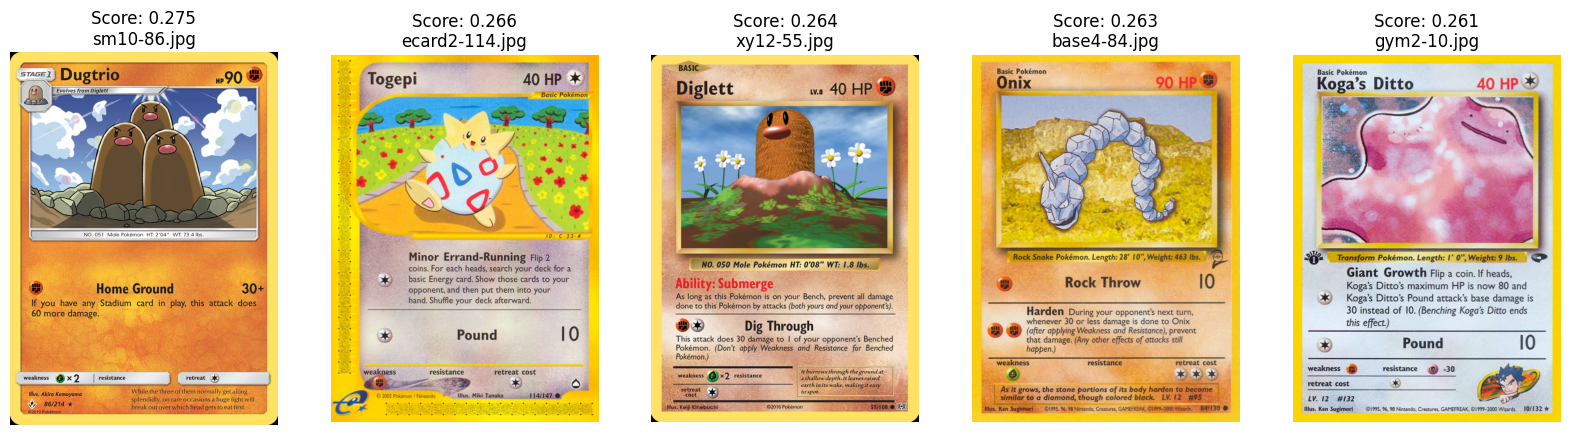

In [72]:
def test_search(query_text, top_k=5):
    # Encode the text query
    print(f"Searching for: '{query_text}'...")
    with torch.no_grad():
        text_inputs = processor(text=[query_text], return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)
        # Normalize the query
        text_features /= text_features.norm(p=2, dim=-1, keepdim=True)

    # Calculate similarity (dot product works since both are normalized)
    # Resulting shape: [1, N_embeddings]
    similarities = (text_features @ embeddings_tensor.T).squeeze(0)

    # Get the top k results
    values, indices = torch.topk(similarities, top_k)

    # Visualize results
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices.cpu().numpy()):
        img_path = reconstructed_image_paths[idx] # Use the reconstructed list for image paths
        score = values[i].item()

        plt.subplot(1, top_k, i + 1)
        plt.imshow(Image.open(img_path))
        plt.title(f"Score: {score:.3f}\n{os.path.basename(img_path)}")
        plt.axis("off")
    plt.show()

# --- RUN THE TEST ---
test_search("thumb in the ground")